In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
sys.path.insert(0, '/mnt/home/raheppt1/projects/age_prediction')
import numpy as np
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# tensorflow-gpu 2.0.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.optimizers import *
import tensorflow_probability as tfp
from scipy.ndimage import gaussian_filter

from dataset import AgeData
from misc import utils
from misc.utils import init_gpu
from models.models3d import age_regression

ModuleNotFoundError: No module named 'dataset'

In [ ]:
# Initialize GPU 
init_gpu(gpu_device='0')

In [ ]:
batch_size = 16

# Switch between test and validation set
select_testset = True
select_dataset = 'IXI'
select_group = 'AD'
select_cv_split = 0
select_test_split = 'split'
config = {
        # General parameters
        'image_size': [100, 120, 100],
        'image_spacing': [1.5, 1.5, 1.5],
    }

image_size = config['image_size']
image_spacing = config['image_spacing']

if select_dataset == 'IXI':
    # IXI
    config['base_folder'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/PP_IXIT1'
    config['file_prefix'] = 'fcmnorm_brain_mni_IXI'
    config['file_suffix'] = '_T1_restore'
    config['file_ext'] = '.nii.gz'
    config['path_training_csv'] = f'/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_train_split{select_cv_split}.csv'
    config['path_validation_csv'] = f'/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_val_split{select_cv_split}.csv'
    config['path_test_csv'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_test.csv'
    config['path_info_csv'] = '/mnt/share/raheppt1/project_data/brain/IXI/IXI_T1/config/IXI_T1_age.csv'
elif select_dataset == 'ADNI':
    # ADNI
    config['base_folder'] = '/mnt/share/raheppt1/project_data/brain/ADNI/ADNI_T1'
    config['file_prefix'] = 'fcmnorm_brain_mni_ADNI_'
    config['file_suffix'] = '_T1'
    config['file_ext'] = '.nii.gz'
    config['path_training_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_train_split{select_cv_split}.csv'
    config['path_validation_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_val_split{select_cv_split}.csv'
    config['path_test_csv'] = f'/mnt/share/raheppt1/project_data/brain/ADNI/config/GR_{select_group}/{select_group}_ADNI_T1_test_{select_test_split}.csv'
    config['path_info_csv'] = '/mnt/share/raheppt1/project_data/brain/ADNI/config/ADNI_age_only.csv'

def create_datasets(config, select_testset):
    # Load training and test data.
    age_data = AgeData(config,
                       shuffle_training_images=True,
                       save_debug_images=False,
                       b_test=select_testset)
    dataset_train = age_data.dataset_train()
    train_samples = dataset_train.num_entries()
    dataset_val = age_data.dataset_val()
    val_samples = dataset_val.num_entries()

    # Define training and validation datasets from generators.
    def train_gen():
        data = dataset_train
        i = 0
        while i < data.num_entries():
            sample = data.get_next()
            # DHWC tensor format
            image = sample['generators']['image'].transpose([1, 2, 3, 0])
            image = image.astype('float32')
            age = sample['generators']['age']
            yield image, age
            i += 1

    def val_gen():
        data = dataset_val
        i = 0
        while i < data.num_entries():
            sample = data.get_next()
            image = sample['generators']['image'].transpose([1, 2, 3, 0])
            #image = gaussian_filter(sample['generators']['image'].transpose([1, 2, 3, 0]), sigma=8.0)# (sample['generators']['image']).transpose([1, 2, 3, 0])
            image = image.astype('float32')
            age = sample['generators']['age']
            yield image, age
            i += 1

    ds_train = tf.data.Dataset.from_generator(train_gen,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=(tf.TensorShape((None, None, None, None)),
                                                             tf.TensorShape((1, ))))
    ds_train = ds_train.batch(batch_size=batch_size)

    ds_val = tf.data.Dataset.from_generator(val_gen,
                                            output_types=(tf.float32, tf.float32),
                                            output_shapes=(tf.TensorShape((None, None, None, None)),
                                                           tf.TensorShape((1, ))))
    ds_val = ds_val.batch(batch_size=batch_size)
    
    return ds_train, ds_val

ds_train, ds_val = create_datasets(config, select_testset)

In [121]:
# Reload model (simple, quantile or aleatoric)
simple_model = tf.saved_model.load('/mnt/share/raheppt1/tf_models/brainage/keras/new_quantile_01/model.tf/')

In [122]:
def mean_mae(y_true, y_pred):
    return tf.keras.losses.MAE(y_true[:, 0], y_pred[:, 0])

def mean_mse(y_true, y_pred):
    return tf.keras.losses.MSE(y_true[:, 0], y_pred[:, 0])

# Predict
preds_list = []
labels_list = []
for test_images, test_labels in ds_val:
    preds = simple_model(test_images, training=False)
    preds_list.append(preds)
    labels_list.append(test_labels)
    # Print metrics for each batch.
    tf.print(f'mae {mean_mae(test_labels, preds):.2f} mse {mean_mse(test_labels, preds):.2f}')
all_labels = tf.concat(labels_list, axis=0)
all_preds = tf.concat(preds_list, axis=0)
tf.print(f'overall mae {mean_mae(all_labels, all_preds):.2f} mse {mean_mse(all_labels, all_preds):.2f}')

mae 2.08 mse 9.00
mae 2.34 mse 7.69
mae 1.98 mse 6.55
mae 2.99 mse 15.95
mae 3.45 mse 27.15
mae 2.52 mse 12.98
mae 2.48 mse 13.40
overall mae 2.56 mse 13.23


In [117]:
all_labels_AD = all_labels
all_preds_AD = all_preds

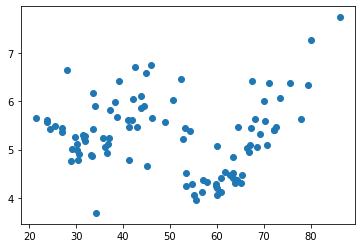

In [123]:
plt.scatter(all_labels[:, 0], all_preds[:, 2]- all_preds[:, 1])

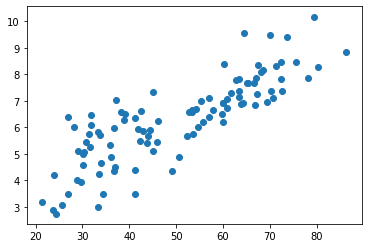

In [120]:
plt.scatter(all_labels[:, 0],tf.sqrt(tf.exp(all_preds[:, 1]**2)))
#tf.exp(all_preds[:, 1])

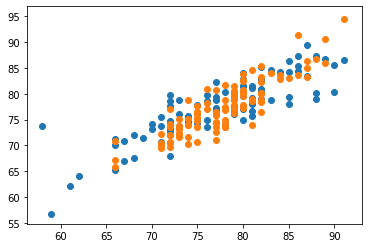

In [87]:
plt.scatter(all_labels_AD[:, 0], all_preds_AD[:, 0])
plt.scatter(all_labels[:, 0], all_preds[:, 0])

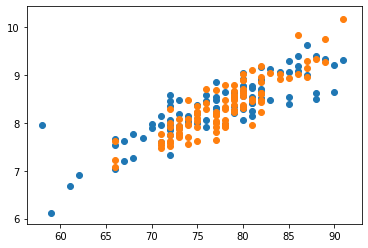

In [89]:
plt.scatter(all_labels_AD[:, 0], all_preds_AD[:, 2]- all_preds_AD[:, 1])
plt.scatter(all_labels[:, 0], all_preds[:, 2]- all_preds[:, 1])

In [73]:
tf.print(f'overall mae {mean_mae(all_labels, all_preds):.2f} mse {mean_mse(all_labels, all_preds):.2f}')

overall mae 2.07 mse 6.66


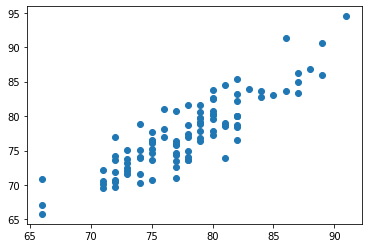

In [74]:
plt.scatter(all_labels[:, 0], all_preds[:, 0])

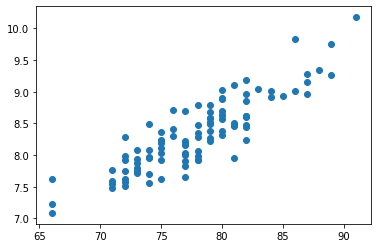

In [75]:
plt.scatter(all_labels[:, 0], all_preds[:, 2]- all_preds[:, 1])